<a href="https://colab.research.google.com/github/daria-kryuchkova/HackBio/blob/main/hackbio_stage_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
#Part 1: Converting genome into protein

def translate_dna_list(dna_list, reading_frame=1):
    """
    Translates a list of DNA sequences into proteins, tolerating invalid sequences.

    Parameters:
        dna_list (list of str): List of DNA sequences.
        reading_frame (int): Reading frame to use (1, 2, or 3).

    Returns:
        pd.DataFrame: Columns = ['DNA', 'Protein', 'ReadingFrame', 'Warning'].
                      Invalid sequences will show the corrupted symbols in 'Warning'
                      and translation will stop at the first invalid nucleotide.
    """

    # Codon table (standard genetic code)
    codon_table = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
        'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
    }

    valid_nucleotides = {'A', 'T', 'C', 'G'}
    results = []

    # Validate reading frame
    if reading_frame not in (1, 2, 3):
        raise ValueError("Reading frame must be 1, 2, or 3.")

    for seq in dna_list:
        dna_sequence = seq.upper().replace(" ", "").replace("\n", "")
        warning = ""
        protein = ""

        if not dna_sequence:
            warning = "Empty sequence"
            protein = ""
        else:
            # Find invalid characters
            invalid_positions = [(i + 1, base) for i, base in enumerate(dna_sequence) if base not in valid_nucleotides]

            if invalid_positions:
                # Extract valid part before first corrupted base
                first_invalid_index = invalid_positions[0][0] - 1
                valid_part = dna_sequence[:first_invalid_index]

                # Prepare warning message
                invalid_symbols = ", ".join([f"{base} at {pos}" for pos, base in invalid_positions])
                warning = f"Invalid nucleotide(s): {invalid_symbols}"

                if valid_part:
                    dna_sequence = valid_part
                else:
                    protein = ""
                    results.append({
                        "DNA": seq,
                        "Protein": protein,
                        "ReadingFrame": reading_frame,
                        "Warning": warning
                    })
                    continue  # skip translation if no valid prefix

            # Trim sequence by reading frame
            frame_seq = dna_sequence[reading_frame - 1:]
            if len(frame_seq) < 3:
                warning = warning + " | Too short to translate" if warning else "Too short to translate"
            elif len(frame_seq) % 3 != 0:
                warning = warning + f" | Length not divisible by 3 (frame {reading_frame})" if warning else f"Length not divisible by 3 (frame {reading_frame})"
                frame_seq = frame_seq[:len(frame_seq) - (len(frame_seq) % 3)]

            # Translate DNA to protein
            for i in range(0, len(frame_seq), 3):
                codon = frame_seq[i:i+3]
                amino_acid = codon_table.get(codon, 'X')
                protein += amino_acid
                if amino_acid == '*':  # stop codon
                    break

        results.append({
            "DNA": seq,
            "Protein": protein,
            "ReadingFrame": reading_frame,
            "Warning": warning
        })

    return pd.DataFrame(results)

In [157]:
#Testing the function on different input

dna_sequences = [
    "ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG",  # valid
    "ATGGCNATTGTAXTGG",                         # invalid with valid prefix
    "NTGTTTAAATGA",                             # starts invalid
    "ATGGCCATTG"                                # valid but not divisible by 3
]

df = translate_dna_list(dna_sequences, reading_frame=1)
df

,DNA,Protein,ReadingFrame,Warning
0,ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG,MAIVMGR*,1,
1,ATGGCNATTGTAXTGG,M,1,"Invalid nucleotide(s): N at 6, X at 13 | Lengt..."
2,NTGTTTAAATGA,,1,Invalid nucleotide(s): N at 1
3,ATGGCCATTG,MAI,1,Length not divisible by 3 (frame 1)


In [158]:
#Part 2: calculating hamming distance between 2 strings

def hamming_distance(str1, str2):
    # normalize (remove '@', lowercase, etc.)
    str1, str2 = str1.lower().strip('@'), str2.lower().strip('@')

    # pad shorter one with spaces
    max_len = max(len(str1), len(str2))
    str1 = str1.ljust(max_len)
    str2 = str2.ljust(max_len)

    # count mismatches
    distance = sum(ch1 != ch2 for ch1, ch2 in zip(str1, str2))
    return distance

In [159]:
hamming_distance("@daria", "@kryuchkova_d")

12

In [160]:
# Task 3: Gene expression analysis and Breast Cancer Data Exploration

# Loading the source data

#URLS
hbr_uhr_url= 'https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/hbr_uhr_top_deg_normalized_counts.csv'
chr22_url = 'https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/hbr_uhr_deg_chr22_with_significance.csv'
br_can_url = 'https://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/data-3.csv'

#Loading data to dataframes
hbr_uhr = pd.read_csv(hbr_uhr_url, index_col=0)
chr22 = pd.read_csv(chr22_url, index_col=0)
br_can = pd.read_csv(br_can_url)

# Ensuring all expression columns are numeric
hbr_uhr = hbr_uhr.apply(pd.to_numeric, errors='coerce')
chr22 = chr22.apply(pd.to_numeric, errors='coerce')

#Checking datasets
print(hbr_uhr.head())
print(chr22.head())
print(br_can.head())

         HBR_1  HBR_2  HBR_3  UHR_1  UHR_2  UHR_3
SULT4A1  375.0  343.6  339.4    3.5    6.9    2.6
MPPED1   157.8  158.4  162.6    0.7    3.0    2.6
PRAME      0.0    0.0    0.0  568.9  467.3  519.2
IGLC2      0.0    0.0    0.0  488.6  498.0  457.5
IGLC3      0.0    0.0    0.0  809.7  313.8  688.0
        log2FoldChange           PAdj  -log10PAdj  significance
name                                                           
SYNGR1            -4.6  5.200000e-217  216.283997           NaN
SEPT3             -4.6  4.500000e-204  203.346787           NaN
YWHAH             -2.5  4.700000e-191  190.327902           NaN
RPL3               1.7  5.400000e-134  133.267606           NaN
PI4KA             -2.0  2.900000e-118  117.537602           NaN
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903    

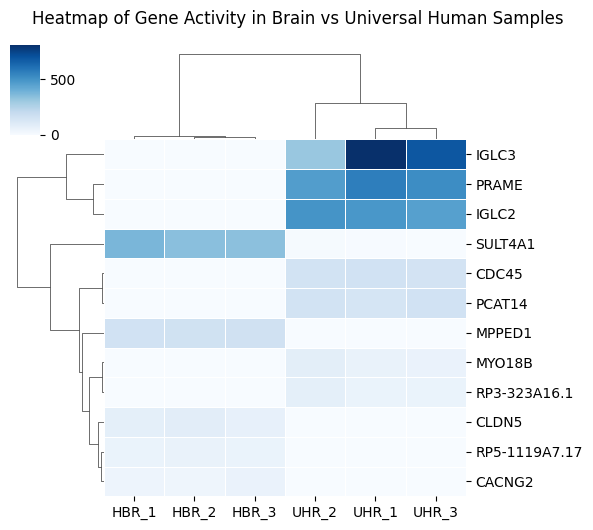

In [161]:
#a. Clustered Heatmap of Gene Activity
df = hbr_uhr.copy()

# Plot clustered heatmap
sns.clustermap(
    df,
    cmap="Blues",
    linewidths=0.5,
    figsize=(6,5),
    #cbar_kws={"label": "Normalized Expression"}
).fig.suptitle("Heatmap of Gene Activity in Brain vs Universal Human Samples", y=1.05)

plt.show()

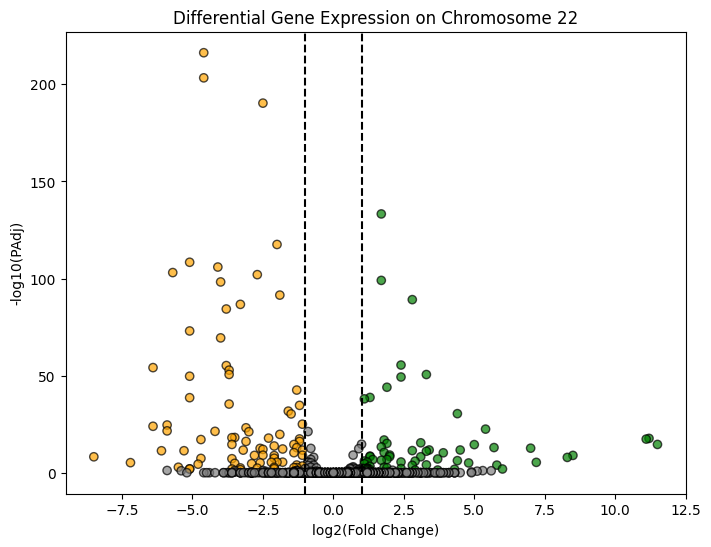

In [162]:
#Volcano plot of Differential Gene Expression
df=chr22.copy()

# Define significance threshold
log2fc_threshold = 1
pval_threshold = 0.05

# Assign significance labels
df['significance'] = 'Not significant'
df.loc[(df['log2FoldChange'] > log2fc_threshold) & (df['PAdj'] < pval_threshold), 'significance'] = 'Upregulated'
df.loc[(df['log2FoldChange'] < -log2fc_threshold) & (df['PAdj'] < pval_threshold), 'significance'] = 'Downregulated'

# Map colors
color_map = {'Upregulated': 'green', 'Downregulated': 'orange', 'Not significant': 'grey'}
df['color'] = df['significance'].map(color_map)

# Volcano plot
plt.figure(figsize=(8,6))
plt.scatter(df['log2FoldChange'], -np.log10(df['PAdj']), c=df['color'], alpha=0.7, edgecolor='k')

# Add dashed vertical lines at log2FC = ±1
plt.axvline(x=1, color='black', linestyle='--')
plt.axvline(x=-1, color='black', linestyle='--')

plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(PAdj)')
plt.title('Differential Gene Expression on Chromosome 22')
plt.show()

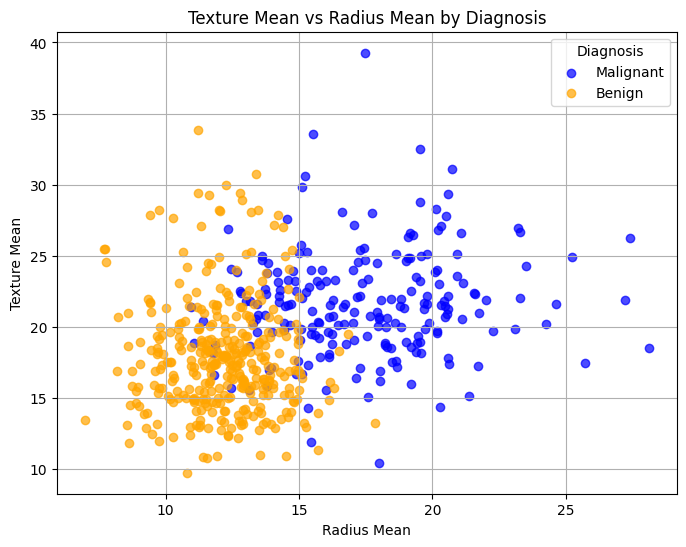

In [163]:
# Scatter plt of texture vs radius means per diagnosis
df = br_can.dropna(subset=['diagnosis', 'radius_mean', 'texture_mean'])

# Mapping for colors and labels
colors = {'M': 'blue', 'B': 'orange'}
labels = {'M': 'Malignant', 'B': 'Benign'}

plt.figure(figsize=(8,6))
for diagnosis in df['diagnosis'].unique():
    subset = df[df['diagnosis'] == diagnosis]
    plt.scatter(subset['radius_mean'], subset['texture_mean'],
                c=colors[diagnosis], label=labels[diagnosis], alpha=0.7)

plt.xlabel('Radius Mean')
plt.ylabel('Texture Mean')
plt.title('Texture Mean vs Radius Mean by Diagnosis')
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()

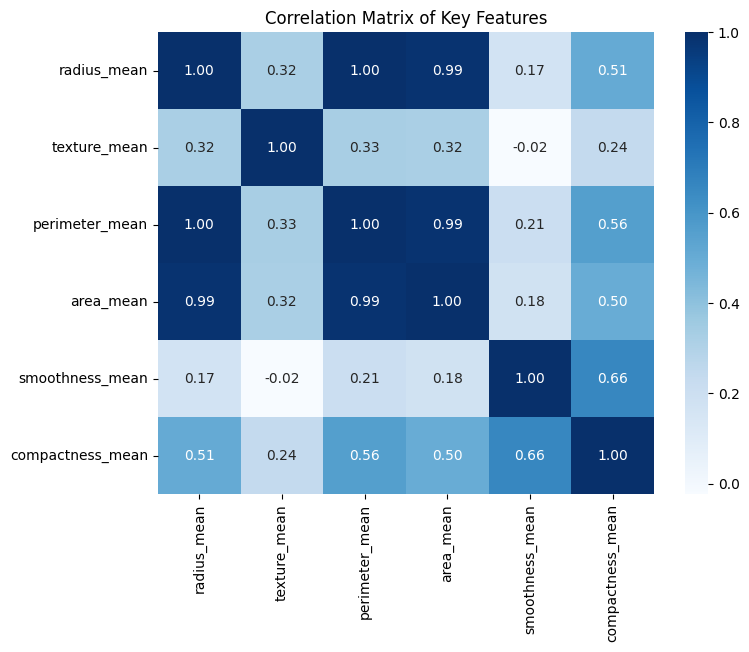

In [164]:
# Correlation heatmap
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
            'area_mean', 'smoothness_mean', 'compactness_mean']

# Compute correlation matrix
corr_matrix = df[features].corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Correlation Matrix of Key Features")
plt.show()

In [165]:
#Key insight: several features ('radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean') have a very strong correlation and can be reduced to one (i.e. radius) as they refer to the size.

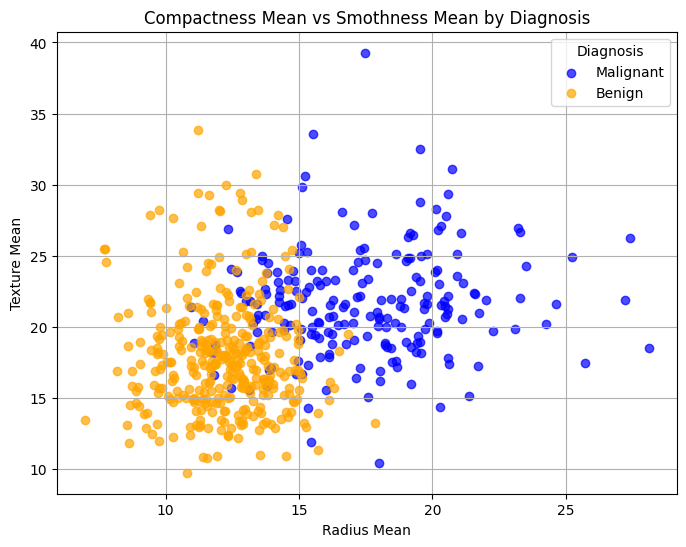

In [166]:
# Scatter plt of texture vs radius means per diagnosis
df = br_can.dropna(subset=['diagnosis', 'compactness_mean', 'smoothness_mean'])

# Mapping for colors and labels
colors = {'M': 'blue', 'B': 'orange'}
labels = {'M': 'Malignant', 'B': 'Benign'}

plt.figure(figsize=(8,6))
for diagnosis in df['diagnosis'].unique():
    subset = df[df['diagnosis'] == diagnosis]
    plt.scatter(subset['radius_mean'], subset['texture_mean'],
                c=colors[diagnosis], label=labels[diagnosis], alpha=0.7)

plt.xlabel('Radius Mean')
plt.ylabel('Texture Mean')
plt.title('Compactness Mean vs Smothness Mean by Diagnosis')
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()

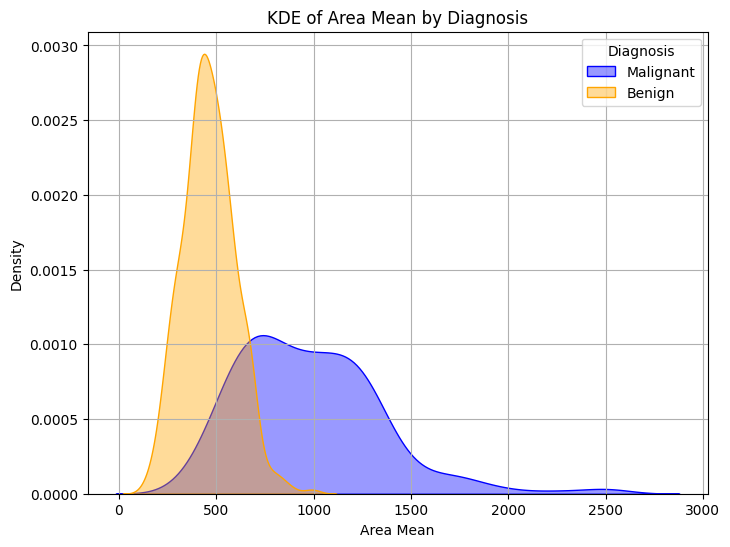

In [167]:
# KDE plot
df = br_can.dropna(subset=['diagnosis', 'area_mean'])

plt.figure(figsize=(8,6))

# KDE for malignant
sns.kdeplot(df[df['diagnosis'] == 'M']['area_mean'],
            color='blue', label='Malignant', fill=True, alpha=0.4)

# KDE for benign
sns.kdeplot(df[df['diagnosis'] == 'B']['area_mean'],
            color='orange', label='Benign', fill=True, alpha=0.4)

plt.xlabel('Area Mean')
plt.ylabel('Density')
plt.title('KDE of Area Mean by Diagnosis')
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()